#**Introduction**

---

**Assessment Title: Movie Recommendation System using IMDB dataset**

*Department of Computing, University of Bournemouth* | *Data Science and Artificial Intelligence*

Yasemin Karaca


---

The increasing growth of the film industry, alongside the extensive availability of streaming
platforms, has made it challenging for users to discover movies that fit their preferences. To
improve user experience and engagement, a movie recommendation system is
developed utilising the IMDB dataset.


***Dataset Description:***
The dataset consists of two CSV files: movies.csv and rating.csv. The movies.csv file contains
movie information such as movieId, title, and genres. The rating.csv file contains user ratings
for movies, including userId, movieId, rating, and timestamp.

##**Install and import libraries**


In [ ]:
pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163003 sha256=476c2a1e036fde216bac56da8b40f973183b793529653145310bcb6ecac912df
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from math import sqrt
from collections import defaultdict
from scipy.linalg import svd

from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split as surprise_train_test_split

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, SimpleRNN
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report



## **Setup and Functions**

In [ ]:
def load_data():
    ratings = pd.read_csv('ratings.csv')
    movies = pd.read_csv('movies.csv')
    return ratings, movies

In [ ]:
def create_matrices(ratings, movies):
    merged_df = pd.merge(ratings, movies, on='movieId')
    user_item_matrix = merged_df.pivot_table(index='userId', columns='title', values='rating', fill_value=0)
    cosine_sim = cosine_similarity(user_item_matrix.T)
    return user_item_matrix, cosine_sim

In [ ]:
def get_user_ratings(user_item_matrix, user_id):
    user_ratings = user_item_matrix.loc[user_id]
    rated_movies = user_ratings[user_ratings > 0].index.tolist()
    return user_ratings, rated_movies

In [ ]:
def get_movie_index(user_item_matrix, movie_title):
    return user_item_matrix.columns.get_loc(movie_title) if movie_title in user_item_matrix.columns else -1

In [ ]:
def calculate_metrics(actual_ratings, predicted_ratings):

    filtered_ratings = [(actual, predicted) for actual, predicted in zip(actual_ratings, predicted_ratings) if predicted is not None]
    if not filtered_ratings:
        return float('nan'), float('nan')

    actuals, estimates = zip(*filtered_ratings)
    rmse = sqrt(mean_squared_error(actuals, estimates))
    mae = mean_absolute_error(actuals, estimates)
    return rmse, mae

In [ ]:
def calculate_classification_metrics(actuals, predictions, threshold=3.5):
    actual_classes = [1 if x > threshold else 0 for x in actuals]
    predicted_classes = [1 if x > threshold else 0 for x in predictions]

    tp = sum((ac == 1) and (pc == 1) for ac, pc in zip(actual_classes, predicted_classes))
    tn = sum((ac == 0) and (pc == 0) for ac, pc in zip(actual_classes, predicted_classes))
    fp = sum((ac == 0) and (pc == 1) for ac, pc in zip(actual_classes, predicted_classes))
    fn = sum((ac == 1) and (pc == 0) for ac, pc in zip(actual_classes, predicted_classes))

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return {"Precision": precision, "Recall": recall, "F1-Score": f1}


# **Collaborative Filtering**

---

## **Cosine Similarity**

In [ ]:
def recommend_movies_cosine(user_item_matrix, cosine_sim, user_id, movie_title, k=10):
    movie_idx = get_movie_index(user_item_matrix, movie_title) # get the index of the movie in the user item matrix
    similar_movies = sorted(list(enumerate(cosine_sim[movie_idx])), key=lambda x: x[1], reverse=True)
    # sort movies based on their cosine similarity with the target movie
    recommendations = [(user_item_matrix.columns[i], score) for i, score in similar_movies[1:k+1]]

    user_ratings = user_item_matrix.loc[user_id]
    predictions = [] # predicting ratings for recommended movies
    for movie, score in recommendations:
        similar_user_ratings = user_item_matrix[movie] # get ratings of users who rated the recommended movie
        if (similar_user_ratings != 0).sum() > 0:
            weighted_ratings = similar_user_ratings * score  # calculate predicted rating using weighted average of similar user's ratings
            predicted_rating = weighted_ratings.sum() / (score * (similar_user_ratings != 0).sum())
        else:
            predicted_rating = user_ratings.mean()  # if no similar users have rated the movie, predict the average rating of the user
        predictions.append((movie, predicted_rating, score))
    return predictions


Predicted ratings and similarity scores for recommended movies:
Incredibles, The (2004): Predicted Rating = 3.8360, Similarity Score = 0.7264
Shrek (2001): Predicted Rating = 3.8676, Similarity Score = 0.7014
Monsters, Inc. (2001): Predicted Rating = 3.8712, Similarity Score = 0.6973
Pirates of the Caribbean: The Curse of the Black Pearl (2003): Predicted Rating = 3.7785, Similarity Score = 0.6523
Shrek 2 (2004): Predicted Rating = 3.5761, Similarity Score = 0.6251
Catch Me If You Can (2002): Predicted Rating = 3.9217, Similarity Score = 0.5942
Lord of the Rings: The Return of the King, The (2003): Predicted Rating = 4.1189, Similarity Score = 0.5873
Lord of the Rings: The Two Towers, The (2002): Predicted Rating = 4.0213, Similarity Score = 0.5681
Harry Potter and the Prisoner of Azkaban (2004): Predicted Rating = 3.9140, Similarity Score = 0.5603
Ocean's Eleven (2001): Predicted Rating = 3.8445, Similarity Score = 0.5568
RMSE: 0.7901, MAE: 0.7125
Precision: 0.8571
Recall: 1.0000
F1-S

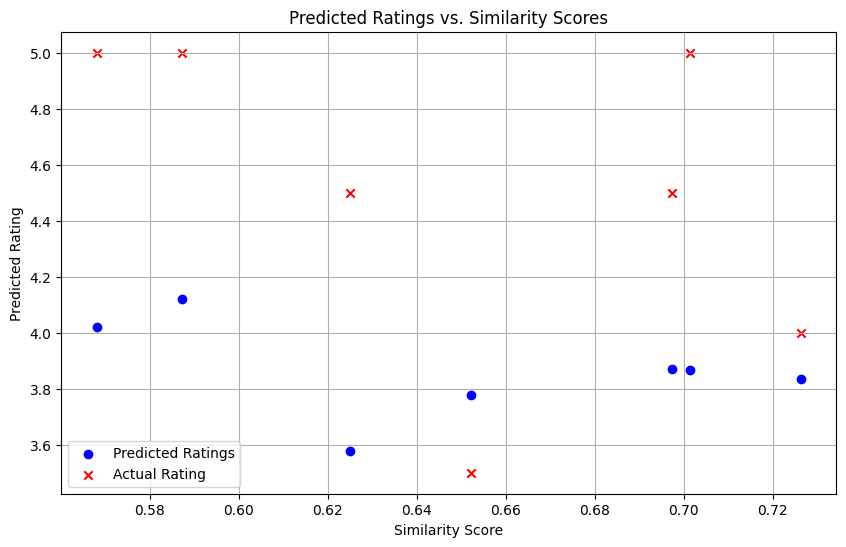

In [ ]:
ratings, movies = load_data()
user_item_matrix, cosine_sim = create_matrices(ratings, movies)

# example usage
movie_title = 'Finding Nemo (2003)'
user_id = 66

predictions = recommend_movies_cosine(user_item_matrix, cosine_sim, user_id, movie_title) # fetching predictions

if predictions:  # analysing predictions
    print("Predicted ratings and similarity scores for recommended movies:")
    for movie, predicted_rating, score in predictions:
       print(f"{movie}: Predicted Rating = {predicted_rating:.4f}, Similarity Score = {score:.4f}")

    # comparison of actual and predicted ratings
    actual_ratings = []
    predicted_ratings = []
    similarity_scores = []
    for movie, predicted_rating, similarity_score in predictions:
        if user_item_matrix.at[user_id, movie] > 0:  # Checking if the user has rated the movie
            actual_ratings.append(user_item_matrix.at[user_id, movie])
            predicted_ratings.append(predicted_rating)
            similarity_scores.append(similarity_score)

    # calculation of metrics
    if actual_ratings:
        rmse, mae = calculate_metrics(actual_ratings, predicted_ratings)
        print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}")

        metrics = calculate_classification_metrics(actual_ratings, predicted_ratings)
        print(f"Precision: {metrics['Precision']:.4f}")
        print(f"Recall: {metrics['Recall']:.4f}")
        print(f"F1-Score: {metrics['F1-Score']:.4f}")

        # create plot
        plt.figure(figsize=(10, 6))
        plt.scatter(similarity_scores, predicted_ratings, color='blue', label='Predicted Ratings')
        for i, actual_rating in enumerate(actual_ratings):
            plt.scatter(similarity_scores[i], actual_rating, color='red', marker='x', label='Actual Rating' if i == 0 else "")

        plt.title('Predicted Ratings vs. Similarity Scores')
        plt.xlabel('Similarity Score')
        plt.ylabel('Predicted Rating')
        plt.legend()
        plt.grid(True)
        plt.show()

## **Singular Value Decomposition (SVD)**

In [ ]:
def svd_process(ratings):
    reader = Reader(rating_scale=(0.5, 5))
    data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
    trainset, testset = surprise_train_test_split(data, test_size=0.2)  # split the data into training and testing sets
    model = SVD()
    model.fit(trainset) # train the SVD model on the training set
    predictions = model.test(testset)
    return model, predictions


In [ ]:
def get_top_n_recommendations(model, ratings, movies, user_id, n=10):
    user_movies = ratings[ratings['userId'] == user_id]['movieId'] # get movies that user has already rated
    user_unrated_movies = movies[~movies['movieId'].isin(user_movies)]['movieId']
    predictions = [(movie_id, model.predict(user_id, movie_id).est) for movie_id in user_unrated_movies]
    top_n = sorted(predictions, key=lambda x: x[1], reverse=True)[:n] # sort predictions by estimated rating in descending order and select top n
    top_n_movies = [(movie_info[0], movies[movies['movieId'] == movie_info[0]]['title'].iloc[0], movie_info[1]) for movie_info in top_n]
    return top_n_movies

In [ ]:
svd_model, svd_predictions = svd_process(ratings)

user_id = 15
top_svd_recommendations = get_top_n_recommendations(svd_model, ratings, movies, user_id)
print("\nTop SVD Recommendations:")
for movie_id, title, predicted_rating in top_svd_recommendations:
    print(f"Movie ID: {movie_id} | Title: {title} | Predicted Rating: {predicted_rating:.2f}")



Top SVD Recommendations:
Movie ID: 1223 | Title: Grand Day Out with Wallace and Gromit, A (1989) | Predicted Rating: 4.33
Movie ID: 1193 | Title: One Flew Over the Cuckoo's Nest (1975) | Predicted Rating: 4.27
Movie ID: 48516 | Title: Departed, The (2006) | Predicted Rating: 4.20
Movie ID: 1213 | Title: Goodfellas (1990) | Predicted Rating: 4.20
Movie ID: 110 | Title: Braveheart (1995) | Predicted Rating: 4.19
Movie ID: 720 | Title: Wallace & Gromit: The Best of Aardman Animation (1996) | Predicted Rating: 4.17
Movie ID: 1104 | Title: Streetcar Named Desire, A (1951) | Predicted Rating: 4.16
Movie ID: 1953 | Title: French Connection, The (1971) | Predicted Rating: 4.15
Movie ID: 1201 | Title: Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966) | Predicted Rating: 4.15
Movie ID: 3681 | Title: For a Few Dollars More (Per qualche dollaro in più) (1965) | Predicted Rating: 4.14


In [ ]:
actual_ratings = [pred.r_ui for pred in svd_predictions] # extracting actual ratings from the SVD predictions
predicted_ratings = [pred.est for pred in svd_predictions if pred.est is not None] # extracting predicted ratings
rmse, mae = calculate_metrics(actual_ratings, predicted_ratings)
print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}")


RMSE: 0.8743, MAE: 0.6698


In [ ]:
svd_classification_predictions = [(pred.r_ui, pred.est) for pred in svd_predictions if pred.est is not None]

actuals, predictions = zip(*svd_classification_predictions)  # unpack the list of tuples into separate lists for actuals and predictions
svd_metrics = calculate_classification_metrics(actuals, predictions)
print(f"Precision: {svd_metrics['Precision']:.4f}\nRecall: {svd_metrics['Recall']:.4f}\nF1-Score: {svd_metrics['F1-Score']:.4f}")

Precision: 0.6740
Recall: 0.7330
F1-Score: 0.7022


## **Neural Collaborative Filtering(NCF)**

In [ ]:
def build_and_train_ncf_model(ratings):
    user_encoder = LabelEncoder() # initialising label encoders for user and movie
    movie_encoder = LabelEncoder()

    ratings['userId'] = user_encoder.fit_transform(ratings['userId'])
    ratings['movieId'] = movie_encoder.fit_transform(ratings['movieId'])

    train, test = train_test_split(ratings, test_size=0.2, random_state=42) # split data into train and test sets
    num_users = ratings['userId'].nunique() # get unique number of users and movies
    num_movies = ratings['movieId'].nunique()

    embedding_size = 50 # setting embedding size

    user_input = Input(shape=(1,), name='user_input') # defining input layers for user and movie IDs
    movie_input = Input(shape=(1,), name='movie_input')

    user_embedding = Embedding(num_users, embedding_size, name='user_embedding')(user_input)
    movie_embedding = Embedding(num_movies, embedding_size, name='movie_embedding')(movie_input)

    user_vec = Flatten(name='flatten_users')(user_embedding)
    movie_vec = Flatten(name='flatten_movies')(movie_embedding)

    concat = Concatenate()([user_vec, movie_vec])# concatenate user and movie vectors

    dense = Dense(128, activation='relu')(concat)
    dense = Dense(64, activation='relu')(dense)
    outputs = Dense(1, activation='linear')(dense)

    model = Model(inputs=[user_input, movie_input], outputs=outputs)    # define and compile the model
    model.compile(optimizer=Adam(0.001), loss='mean_squared_error')

    history = model.fit( # train the model
        [train['userId'].values, train['movieId'].values],
        train['rating'].values,
        batch_size=32,
        epochs=5,
        validation_data=(
            [test['userId'].values, test['movieId'].values],
            test['rating'].values
        )
    )

    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    test_predictions = model.predict([test['userId'].values, test['movieId'].values]).flatten()
    rmse = sqrt(mean_squared_error(test['rating'].values, test_predictions))
    mae = mean_absolute_error(test['rating'].values, test_predictions)
    return model, rmse, mae, user_encoder, movie_encoder, test

In [ ]:
def recommend_movies_ncf(model, ratings, movies, user_id, user_encoder, movie_encoder, top_n=10):
    user_idx = user_encoder.transform([user_id])[0] # converting user id to its encoded form
    rated_user_movies = ratings[ratings['userId'] == user_id]['movieId'].unique() # finding movies already rated by the user

    all_movie_ids = movies['movieId'].unique()
    movies_to_predict = np.setdiff1d(all_movie_ids, rated_user_movies)

    valid_movie_ids = [mid for mid in movies_to_predict if mid in movie_encoder.classes_]  # filtering out movie ids that are not in the movie encoder's classes

    user_idx_array = np.array([user_idx] * len(valid_movie_ids))  # repeat user index for each valid movie id
    movie_idx_array = movie_encoder.transform(valid_movie_ids)  # encode valid movie ids

    predictions = model.predict([user_idx_array, movie_idx_array]).flatten()
    predictions = np.clip(predictions, 0.5, 5)

    top_n_indices = predictions.argsort()[-top_n:][::-1]
    recommended_movie_ids = np.array(valid_movie_ids)[top_n_indices]
    recommended_movie_scores = predictions[top_n_indices]

    recommended_movies = movies[movies['movieId'].isin(recommended_movie_ids)]
    recommended_movies = recommended_movies.copy()
    recommended_movies.loc[:, 'predicted_rating'] = recommended_movie_scores

    recommended_movies = recommended_movies.sort_values('predicted_rating', ascending=False)

    return recommended_movies[['title', 'predicted_rating']]

In [ ]:
def prepare_ncf_predictions(model, test, user_encoder, movie_encoder):
    test_predictions = model.predict([test['userId'].values, test['movieId'].values]).flatten()
    actual_predicted = list(zip(test['rating'].values, test_predictions))  # combining actual and predicted ratings
    return actual_predicted

Epoch 1/5
2521/2521 [==============================] - 39s 14ms/step - loss: 0.9621 - val_loss: 0.8206
Epoch 2/5
2521/2521 [==============================] - 26s 10ms/step - loss: 0.7081 - val_loss: 0.7689
Epoch 3/5
2521/2521 [==============================] - 25s 10ms/step - loss: 0.6543 - val_loss: 0.7651
Epoch 4/5
2521/2521 [==============================] - 26s 10ms/step - loss: 0.5996 - val_loss: 0.7828
Epoch 5/5
2521/2521 [==============================] - 27s 11ms/step - loss: 0.5294 - val_loss: 0.8245


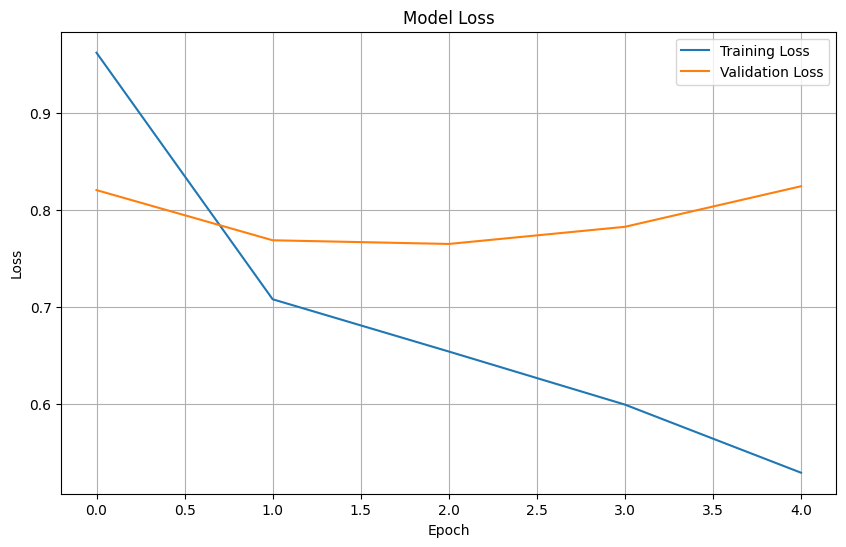

631/631 [==============================] - 1s 1ms/step

RMSE: 0.9080
MAE: 0.6882
NCF Model Trained


In [ ]:
ncf_model, ncf_rmse, ncf_mae, user_encoder, movie_encoder, test = build_and_train_ncf_model(ratings)
print(f"\nRMSE: {ncf_rmse:.4f}\nMAE: {ncf_mae:.4f}")
print("NCF Model Trained")


In [ ]:
user_id = 10
ncf_recommendations = recommend_movies_ncf(ncf_model, ratings, movies, user_id, user_encoder, movie_encoder)
print("NCF Recommendations:")
display(ncf_recommendations)

ncf_predictions = prepare_ncf_predictions(ncf_model, test, user_encoder, movie_encoder)
actuals, predictions = zip(*ncf_predictions)

ncf_classification_metrics = calculate_classification_metrics(actuals, predictions, threshold = 3.5)
print(f"Precision: {ncf_classification_metrics['Precision']:.4f}")
print(f"Recall: {ncf_classification_metrics['Recall']:.4f}")
print(f"F1-Score: {ncf_classification_metrics['F1-Score']:.4f}")

303/303 [==============================] - 1s 3ms/step
NCF Recommendations:


,title,predicted_rating
62,From Dusk Till Dawn (1996),5.000000
592,"Rock, The (1996)",5.000000
1714,Nashville (1975),4.976501
1961,eXistenZ (1999),4.829728
2959,Billy Elliot (2000),4.826491
3734,Hangar 18 (1980),4.773508
5580,Bad Boy Bubby (1993),4.769041
7041,Fired Up (2009),4.762200
8485,The Hundred-Foot Journey (2014),4.719678
9349,Jim Jefferies: Freedumb (2016),4.705194


631/631 [==============================] - 1s 2ms/step
Precision: 0.6500
Recall: 0.7791
F1-Score: 0.7087


##**K-Nearest Neighbour (KNN)**

In [ ]:
def knn_recommendation(user_item_matrix, movie_title, k=10):
    nbrs = NearestNeighbors(n_neighbors=k, metric='cosine').fit(user_item_matrix.values.T)  # fit k nearest neighbors model
    distances, indices = nbrs.kneighbors(user_item_matrix[movie_title].values.reshape(1, -1))  # find distances and indices of nearest neighbors
    return distances, indices

In [ ]:
def evaluate_knn_recommendation(user_item_matrix, movie_title, k=5):
    distances, indices = knn_recommendation(user_item_matrix, movie_title, k)  # get distances and indices of nearest neighbors and get recommendations
    recommendations = [user_item_matrix.columns[idx] for idx in indices.flatten() if idx != 0]

    actual_ratings, predicted_ratings = [], []
    for movie in recommendations:
        if movie != movie_title:
            actual_rating = user_item_matrix[movie_title].mean()
            predicted_rating = user_item_matrix[movie].mean()
            actual_ratings.append(actual_rating)
            predicted_ratings.append(predicted_rating)

    rmse, mae = calculate_metrics(actual_ratings, predicted_ratings)
    return rmse, mae

In [ ]:
movie_title = 'Toy Story (1995)'
distances, indices = knn_recommendation(user_item_matrix, movie_title) # get distances and indices of nearest neighbors for the movie

print("KNN Recommendations for", movie_title)
for i in range(1, len(indices.flatten())):
    print(i, user_item_matrix.columns[indices.flatten()[i]])


rmse, mae = evaluate_knn_recommendation(user_item_matrix, movie_title)
print("RMSE:", rmse)
print("MAE:", mae)

def evaluate_user_recommendation_classification_metrics(user_item_matrix, user_id, threshold=3.5, k=5):
    user_ratings, rated_movies = get_user_ratings(user_item_matrix, user_id)

    relevant_movies = user_item_matrix.loc[user_id][user_item_matrix.loc[user_id] > threshold].index.tolist()  # getting relevant movies rated above threshold

    recommended_movies = []
    for movie_title in rated_movies:
        distances, indices = knn_recommendation(user_item_matrix, movie_title, k)
        recommendations = [user_item_matrix.columns[idx] for idx in indices.flatten() if idx != 0]
        recommended_movies.extend(recommendations)

    recommended_movies = list(set(recommended_movies))

    true_positives = sum(1 for movie in recommended_movies if movie in relevant_movies)
    false_positives = len(recommended_movies) - true_positives
    false_negatives = len(relevant_movies) - true_positives

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return {"Precision": precision, "Recall": recall, "F1-Score": f1_score}

user_id = 1
classification_metrics = evaluate_user_recommendation_classification_metrics(user_item_matrix, user_id)
print("Precision:", classification_metrics["Precision"])
print("Recall:", classification_metrics["Recall"])
print("F1-Score:", classification_metrics["F1-Score"])



KNN Recommendations for Toy Story (1995)
1 Toy Story 2 (1999)
2 Jurassic Park (1993)
3 Independence Day (a.k.a. ID4) (1996)
4 Star Wars: Episode IV - A New Hope (1977)
5 Forrest Gump (1994)
6 Lion King, The (1994)
7 Star Wars: Episode VI - Return of the Jedi (1983)
8 Mission: Impossible (1996)
9 Groundhog Day (1993)
RMSE: 0.44255653721540267
MAE: 0.36229508196721305
Precision: 0.36968576709796674
Recall: 1.0
F1-Score: 0.5398110661268556


## **Recurrent Neural Networks (RNN)**

In [ ]:
def prepare_sequences(data, num_users, num_movies):
    user_sequences = data['userId'].values
    movie_sequences = data['movieId'].values
    ratings = data['rating'].values
    return user_sequences, movie_sequences, ratings

In [ ]:
def create_model(num_users, num_movies):
    user_input = Input(shape=(1,))
    movie_input = Input(shape=(1,))

    user_embedding = Embedding(input_dim=num_users, output_dim=50)(user_input)
    movie_embedding = Embedding(input_dim=num_movies, output_dim=50)(movie_input)

    concatenated = Concatenate()([user_embedding, movie_embedding])
    rnn_output = SimpleRNN(units=50)(concatenated) # define SimpleRNN layer
    output = Dense(units=1, activation='linear')(rnn_output) # output layer

    model = Model(inputs=[user_input, movie_input], outputs=output) # define and compile the model
    model.compile(optimizer='adam', loss='mse')

    return model

In [ ]:
def recommend_movies(model, user_id, num_recommendations=10):
    all_movie_ids = np.arange(num_movies)
    user_ids = np.full_like(all_movie_ids, user_id)  # repeat user id for all movie ids
    predicted_ratings = model.predict([user_ids, all_movie_ids])
    top_indices = (-predicted_ratings.squeeze()).argsort()[:num_recommendations]
    recommended_movie_ids = all_movie_ids[top_indices]
    recommended_movies = movies[movies['movieId'].isin(recommended_movie_ids)]['title'].values
    return recommended_movies

encoder = LabelEncoder()
ratings['userId'] = encoder.fit_transform(ratings['userId'])
ratings['movieId'] = encoder.fit_transform(ratings['movieId'])
ratings['rating'] = ratings['rating'].astype(np.float32)

train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=42) # split data

num_users = ratings['userId'].nunique()
num_movies = ratings['movieId'].nunique()

train_user_sequences, train_movie_sequences, train_ratings = prepare_sequences(train_data, num_users, num_movies) # prepare training sequences

model = create_model(num_users, num_movies) # create the recommendation model
history = model.fit(x=[train_user_sequences, train_movie_sequences], y=train_ratings, epochs=5, batch_size=64, validation_split=0.1) # train the model

user_id = 10
recommended_movies = recommend_movies(model, user_id) # get recommended movies for the specified user
print("Recommended movies for user", user_id, ":")
for i, movie in enumerate(recommended_movies, 1):
    print(i, ".", movie)

Epoch 1/5
1135/1135 [==============================] - 16s 12ms/step - loss: 1.3713 - val_loss: 0.8294
Epoch 2/5
1135/1135 [==============================] - 11s 10ms/step - loss: 0.7273 - val_loss: 0.7901
Epoch 3/5
1135/1135 [==============================] - 12s 10ms/step - loss: 0.6896 - val_loss: 0.7763
Epoch 4/5
1135/1135 [==============================] - 12s 11ms/step - loss: 0.6706 - val_loss: 0.7765
Epoch 5/5
304/304 [==============================] - 1s 2ms/step
Recommended movies for user 10 :
1 . Miracle on 34th Street (1994)
2 . House Arrest (1996)
3 . Little Princess, The (1939)
4 . Hocus Pocus (1993)
5 . Rocky II (1979)
6 . Gate, The (1987)
7 . Secret Window (2004)


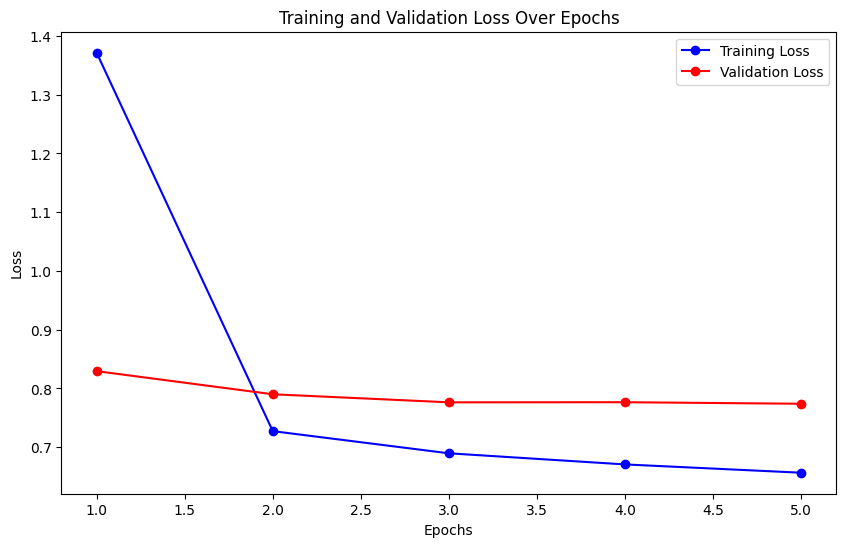

In [ ]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, 'bo-', label='Training Loss')
plt.plot(epochs, validation_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
test_user_sequences, test_movie_sequences, test_ratings = prepare_sequences(test_data, num_users, num_movies)
predicted_ratings = model.predict([test_user_sequences, test_movie_sequences]).flatten()

rmse, mae = calculate_metrics(test_ratings, predicted_ratings)
print("RMSE:", rmse)
print("MAE:", mae)


631/631 [==============================] - 1s 2ms/step
RMSE: 0.8837579036720726
MAE: 0.6767721


In [ ]:
classification_metrics = calculate_classification_metrics(test_ratings, predicted_ratings.squeeze(), threshold=3.5)

print("Precision:", classification_metrics["Precision"])
print("Recall:", classification_metrics["Recall"])
print("F1-Score:", classification_metrics["F1-Score"])


Precision: 0.667575179431271
Recall: 0.7582292849035187
F1-Score: 0.7100202918156343


# **Content-Based Filtering Algorithm**

In [ ]:
def extract_features(data):
    tfidf = TfidfVectorizer(stop_words='english') # initialize TF-IDF vectorizer
    tfidf_matrix = tfidf.fit_transform(data['genres'])  # transform genre data into TF-IDF matrix
    return tfidf_matrix

def build_similarity_matrix(data):
    feature_matrix = extract_features(data)  # extract features from movie genres
    cosine_sim_matrix = cosine_similarity(feature_matrix, feature_matrix)
    return cosine_sim_matrix

def recommend_movies_by_genre(genre, movies, top_n=10):
    genre_movies = movies[movies['genres'].str.contains(genre, case=False, na=False)] # filter movies based on the specified genre
    return genre_movies.sample(n=top_n if len(genre_movies) >= top_n else len(genre_movies))

In [ ]:
from IPython.display import display

movies['genres'] = movies['genres'].fillna('')

input_genre = 'Animation'
recommended_movies = recommend_movies_by_genre(input_genre, movies, top_n=10)

print("Recommended Movies:")
display(recommended_movies[['title', 'genres']])

Recommended Movies:


,title,genres
6530,"Simpsons Movie, The (2007)",Animation|Comedy
4348,Laputa: Castle in the Sky (Tenkû no shiro Rapy...,Action|Adventure|Animation|Children|Fantasy|Sc...
9381,Your Name. (2016),Animation|Drama|Fantasy|Romance
9588,Bobik Visiting Barbos (1977),Animation|Comedy
9453,The Spirit of Christmas (1995),Animation|Comedy
8239,Planes (2013),Adventure|Animation|Comedy
7904,Dragon Ball: Mystical Adventure (Doragon bôru:...,Action|Adventure|Animation|Children
7903,Superman/Batman: Public Enemies (2009),Action|Animation|Fantasy
7074,Watchmen: Tales of the Black Freighter (2009),Action|Adventure|Animation|Horror
9334,Ice Age: Collision Course (2016),Adventure|Animation|Children|Comedy


# **Hybrid Recommendation**

In [ ]:
def recommend_genre_based_movies(ratings, movies, model, user_id, genre):

    genre_movies = movies[movies['genres'].str.contains(genre, case=False, na=False)] # filtering movies by genre

    user_rated_movies = ratings[ratings['userId'] == user_id]['movieId'] # identifying movies rated by user
    unrated_movies = genre_movies[~genre_movies['movieId'].isin(user_rated_movies)]

    predictions = [(row['title'], model.predict(user_id, row['movieId']).est)
                   for _, row in unrated_movies.iterrows()]
    predictions.sort(key=lambda x: x[1], reverse=True)

    return predictions[:10]

In [ ]:
svd_model, _ = svd_process(ratings) # get SVD model
user_id = 73
genre = 'Sci-Fi'
recommendations = recommend_genre_based_movies(ratings, movies, svd_model, user_id, genre) # get genre-based movie recommendations for the user using SVD model

recommendations_hb = pd.DataFrame(recommendations, columns=['Title', 'Predicted Rating'])

print("Recommended Movies: ")
display(recommendations_hb)

Recommended Movies: 


,Title,Predicted Rating
0,Solo (1996),4.905276
1,"Alphaville (Alphaville, une étrange aventure d...",4.750341
2,Tremors (1990),4.649476
3,Invasion of the Body Snatchers (1978),4.630039
4,Godzilla (1998),4.587015
5,Star Trek II: The Wrath of Khan (1982),4.574825
6,Making Mr. Right (1987),4.557006
7,Children of Dune (2003),4.551070
8,Heavy Metal 2000 (2000),4.546609
9,"Thing, The (1982)",4.534279


In [ ]:
def get_actual_and_predicted_ratings(ratings, movies, model, user_id):
    user_ratings = ratings[ratings['userId'] == user_id]
    predictions = [(row['movieId'], row['rating'], model.predict(user_id, row['movieId']).est)
                   for _, row in user_ratings.iterrows()]

    actual_ratings = [rating for _, rating, _ in predictions]
    predicted_ratings = [pred for _, _, pred in predictions]

    return actual_ratings, predicted_ratings

actual_ratings, predicted_ratings = get_actual_and_predicted_ratings(ratings, movies, svd_model, user_id)
rmse, mae = calculate_metrics(actual_ratings, predicted_ratings)
classification_metrics = calculate_classification_metrics(actual_ratings, predicted_ratings)

print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}")
print(f"Precision: {classification_metrics['Precision']:.4f}, Recall: {classification_metrics['Recall']:.4f}, F1-Score: {classification_metrics['F1-Score']:.4f}")

RMSE: 0.4949, MAE: 0.4120
Precision: 0.8171, Recall: 1.0000, F1-Score: 0.8994


#**Decision Tree**

In [ ]:
data = pd.merge(ratings, movies, on='movieId')
data['like'] = (data['rating'] > 3.5).astype(int) # create a binary 'like' column based on rating threshold (3.5)

features = data[['userId', 'movieId']] # selecting features and target variables
target = data['like']

encoder = LabelEncoder()  # encode categorical features (userId and movieId) using LabelEncoder
features.loc[:, 'userId'] = encoder.fit_transform(features['userId'])
features.loc[:, 'movieId'] = encoder.fit_transform(features['movieId'])


X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


In [ ]:
dtree = DecisionTreeClassifier(max_depth=10, random_state=42) # train a Decision Tree Classifier

dtree.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=10, random_state=42)

In [ ]:
y_pred = dtree.predict(X_test) # making predictions on the test set
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.6239577129243598


In [ ]:
def recommend_movies(model, user_id, movie_data, N=10):
    unseen_movies = movie_data[~movie_data['movieId'].isin(ratings[ratings['userId'] == user_id]['movieId'])].copy()
    unseen_movies['userId'] = user_id

    unseen_movies['like_probability'] = model.predict_proba(unseen_movies[['userId', 'movieId']])[:, 1] # predict probabilities of liking for unseen movies

    recommendations = unseen_movies.sort_values('like_probability', ascending=False).head(N)
    return recommendations

user_id = 92
recommended_movies = recommend_movies(dtree, user_id, movies)
print(recommended_movies[['title', 'like_probability']])


                                                  title  like_probability
264                                    Roommates (1995)          1.000000
551                    James and the Giant Peach (1996)          1.000000
265                Ready to Wear (Pret-A-Porter) (1994)          1.000000
552                                         Fear (1996)          1.000000
553                Kids in the Hall: Brain Candy (1996)          1.000000
597                                      Thinner (1996)          1.000000
266    Three Colors: Red (Trois couleurs: Rouge) (1994)          1.000000
563   Alphaville (Alphaville, une étrange aventure d...          0.878049
562                      Run of the Country, The (1995)          0.878049
6528                                     Hot Rod (2007)          0.873684


In [ ]:
rmse = sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("RMSE:", rmse)
print("MAE:", mae)


RMSE: 0.613222869009009
MAE: 0.37604228707564025


In [ ]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)


Precision: 0.6297650130548302
Recall: 0.5530418832161419
F1-Score: 0.5889151135346301


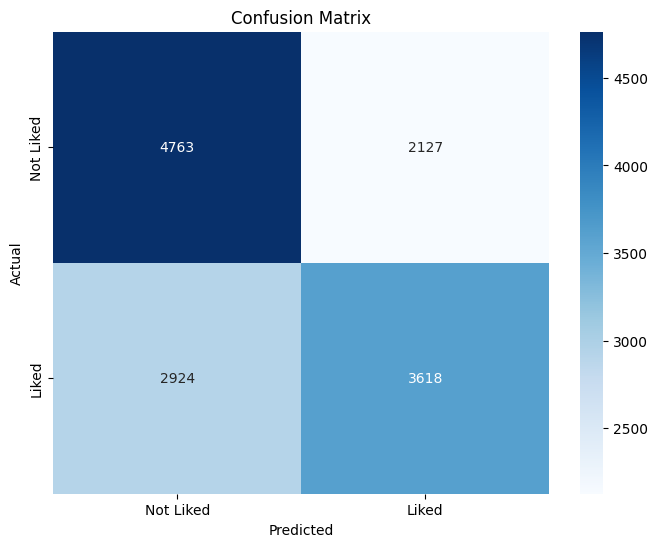

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Not Liked', 'Liked'], yticklabels=['Not Liked', 'Liked'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#**Comparison of Evaluation**

---

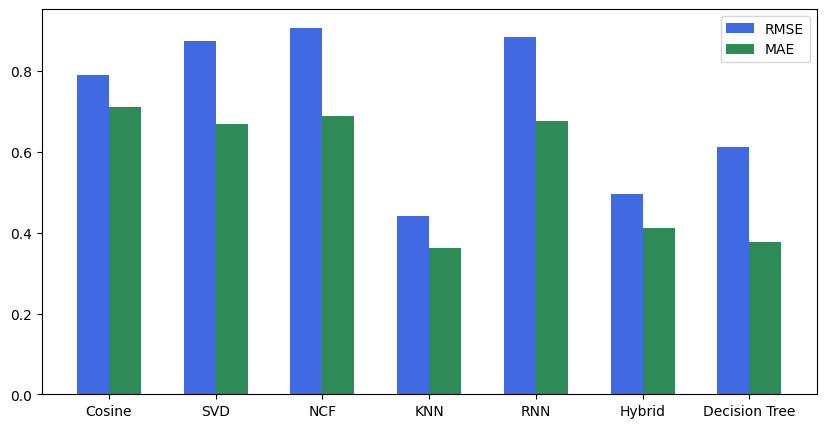

In [ ]:
models = ['Cosine', 'SVD', 'NCF', 'KNN', 'RNN', 'Hybrid', 'Decision Tree']
rmse_values = [0.7901, 0.8743, 0.9080, 0.4425, 0.8837, 0.4949, 0.6132]
mae_values = [0.7125, 0.6698, 0.6882, 0.3622, 0.6767, 0.4120, 0.3760]

fig, ax = plt.subplots(figsize=(10, 5))
index = np.arange(len(models))
bar_width = 0.30
ax.bar(index, rmse_values, bar_width, label='RMSE', color='royalblue')
ax.bar(index + bar_width, mae_values, bar_width, label='MAE', color='seagreen')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(models)
ax.legend()
plt.show()


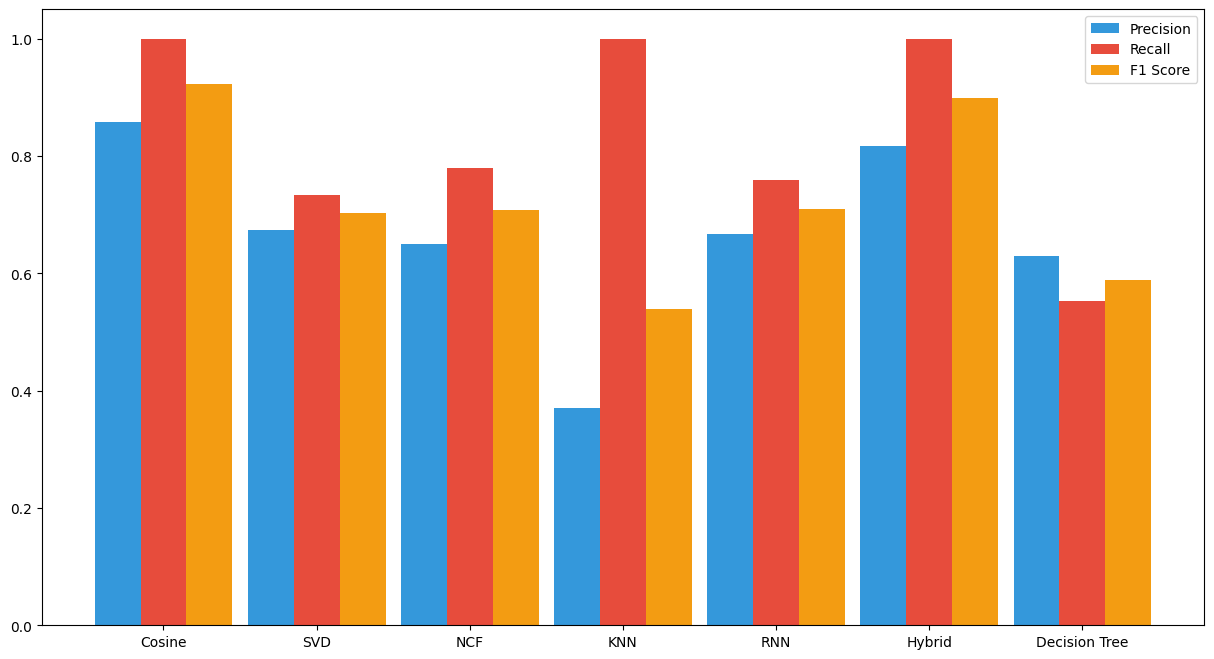

In [ ]:
metrics_data = {
    'Method': models,
    'Precision': [0.8571, 0.6740, 0.6500, 0.3696, 0.6675, 0.8171, 0.6297],
    'Recall': [1.000, 0.7330, 0.7791, 1.0, 0.7582, 1.000, 0.5530],
    'F1 Score': [0.9231, 0.7022, 0.7087, 0.5398, 0.7100, 0.8994, 0.5889]
}

df = pd.DataFrame(metrics_data)
fig, ax = plt.subplots(figsize=(15, 8))
colors = ['#3498db', '#e74c3c', '#f39c12']

for i, col in enumerate(['Precision', 'Recall', 'F1 Score']):
    ax.bar(index + i * bar_width, df[col], bar_width, label=col, color=colors[i])
ax.set_xticks(index + bar_width)
ax.set_xticklabels(df['Method'])
ax.legend()
plt.show()


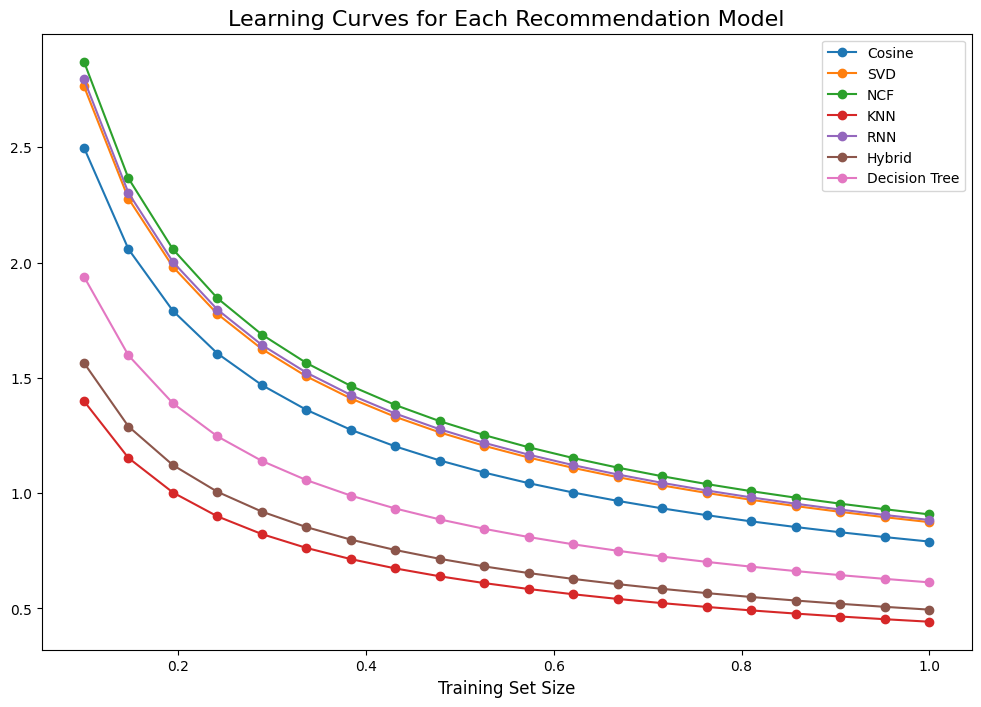

In [ ]:
training_sizes = np.linspace(0.1, 1.0, 20)
learning_curves = {model: base_rmse / np.sqrt(training_sizes) for model, base_rmse in zip(models, rmse_values)}
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title('Learning Curves for Each Recommendation Model', fontsize=16)
ax.set_xlabel('Training Set Size', fontsize=12)
for model, values in learning_curves.items():
    ax.plot(training_sizes, values, marker='o', label=model)
ax.legend()
plt.show()